Processing assets/bubbles.jpeg ...


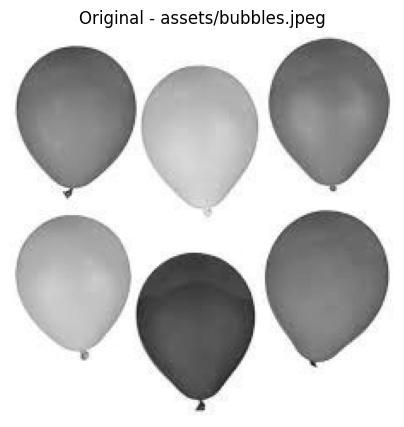

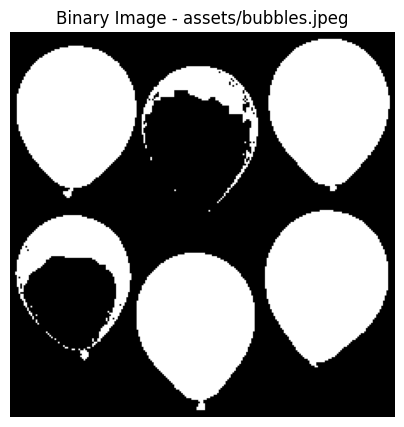

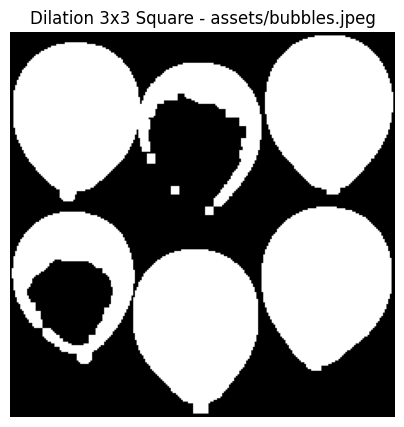

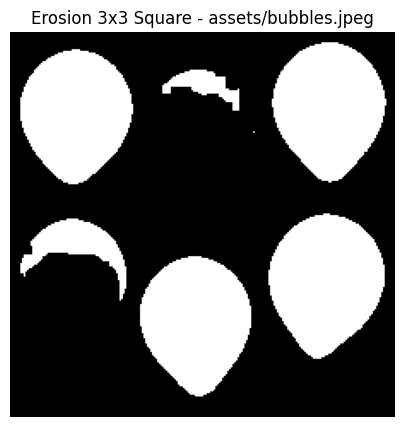

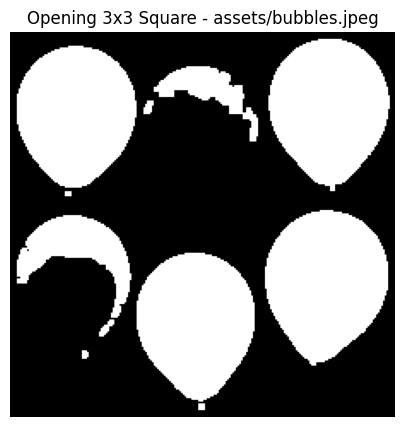

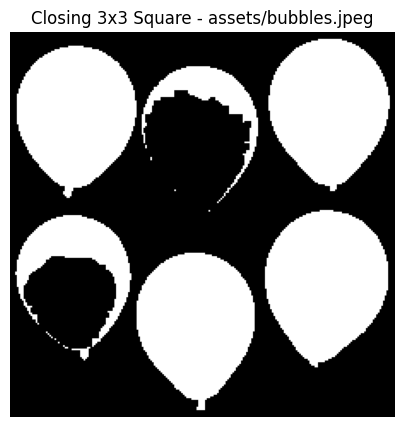

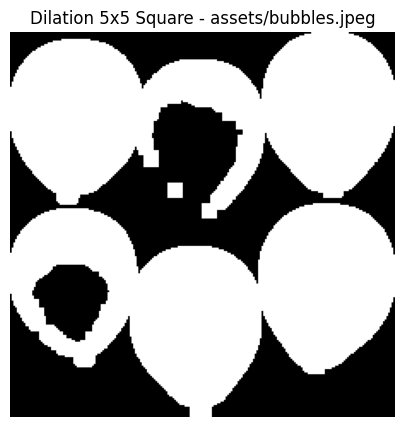

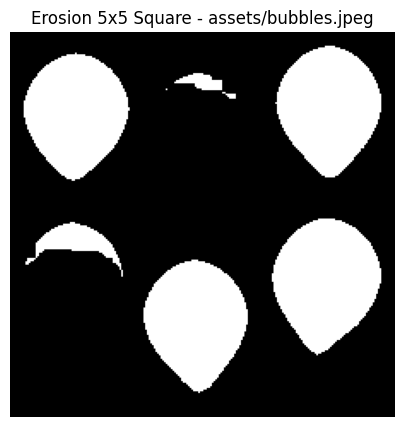

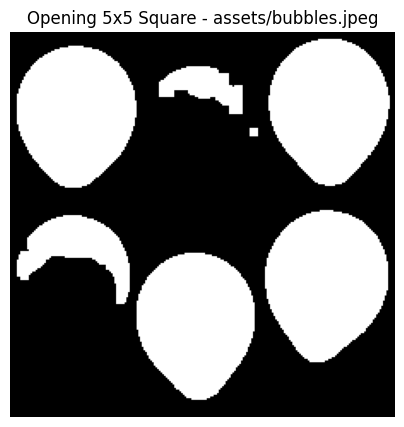

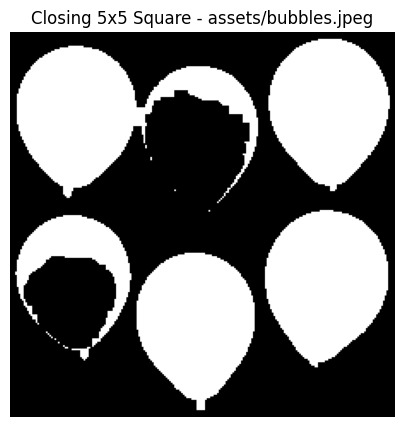

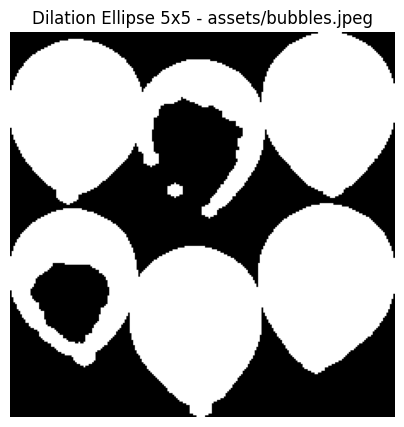

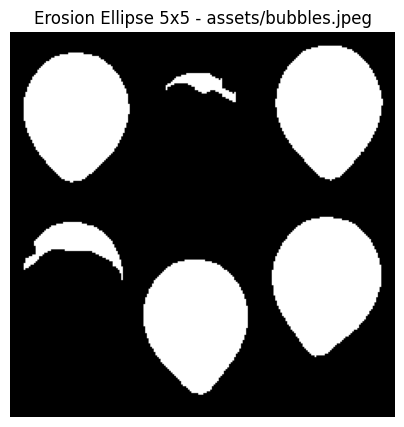

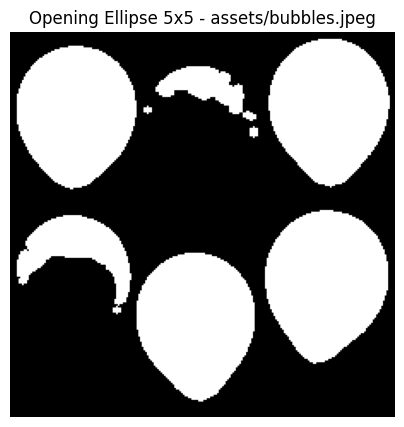

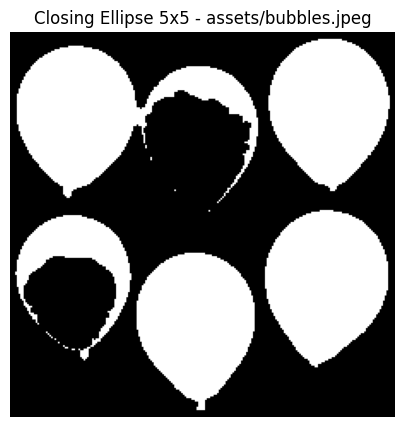

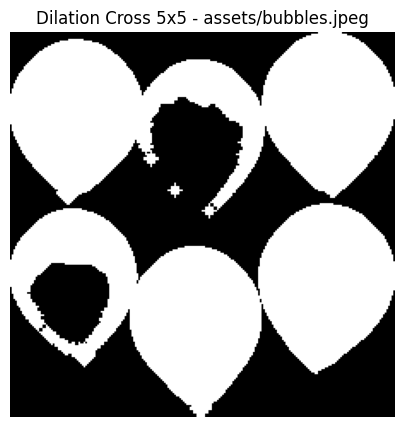

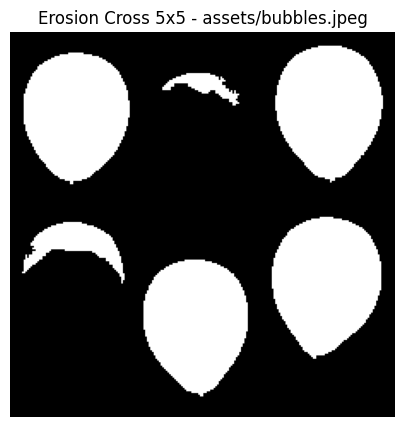

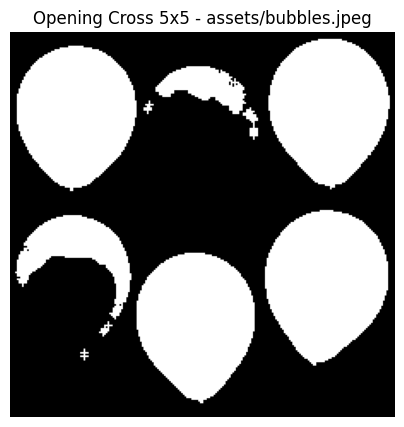

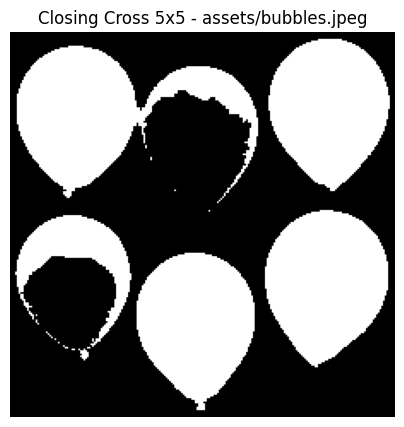

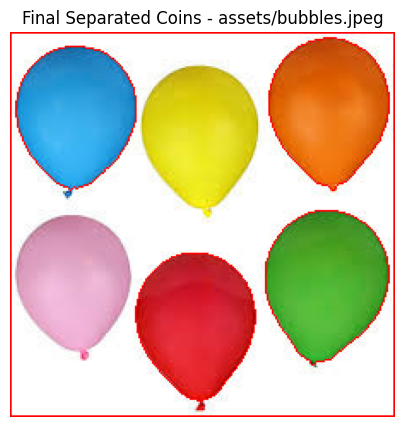

In [65]:
# Coin Separation for Multiple Images
# ===================================

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Utility to display images inline
def show_img(title, img, cmap="gray"):
    plt.figure(figsize=(5,5))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()

# List of coin images
coin_images = [
    "assets/bubbles.jpeg"
]

# Structuring elements to try
kernels = {
    "3x3 Square": cv2.getStructuringElement(cv2.MORPH_RECT, (3,3)),
    "5x5 Square": cv2.getStructuringElement(cv2.MORPH_RECT, (5,5)),
    "Ellipse 5x5": cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)),
    "Cross 5x5": cv2.getStructuringElement(cv2.MORPH_CROSS, (5,5))
}

# Loop through all coin images
for img_path in coin_images:
    print(f"Processing {img_path} ...")
    
    # Step 1: Load image
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    show_img(f"Original - {img_path}", gray)
    
    # Step 2: Threshold
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    show_img(f"Binary Image - {img_path}", binary)
    
    # Step 3: Morphological operations with different kernels
    for name, kernel in kernels.items():
        dilated = cv2.dilate(binary, kernel, iterations=2)
        eroded = cv2.erode(binary, kernel, iterations=2)
        opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
        closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

        show_img(f"Dilation {name} - {img_path}", dilated)
        show_img(f"Erosion {name} - {img_path}", eroded)
        show_img(f"Opening {name} - {img_path}", opening)
        show_img(f"Closing {name} - {img_path}", closing)

    # Step 4: Advanced separation with Distance Transform + Watershed
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)

    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    result = image.copy()
    markers = cv2.watershed(result, markers)
    result[markers == -1] = [0, 0, 255]  # boundaries marked in red

    show_img(f"Final Separated Coins - {img_path}", cv2.cvtColor(result, cv2.COLOR_BGR2RGB))


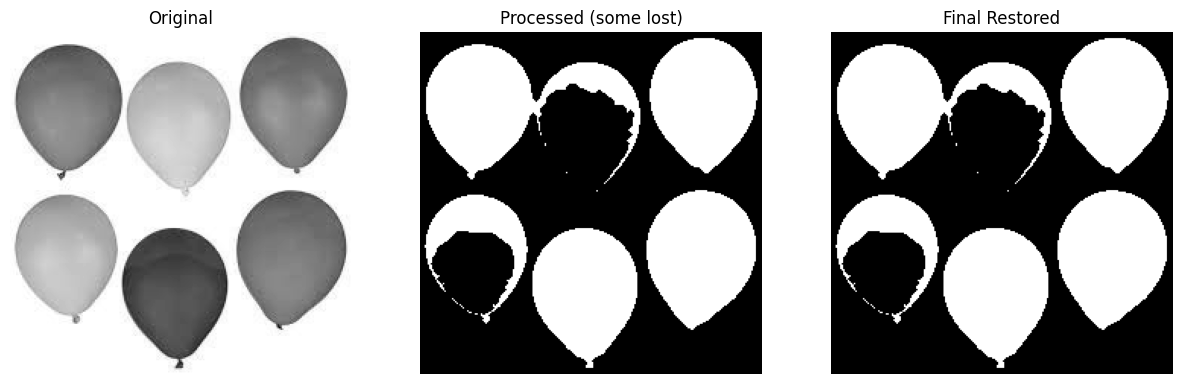

In [70]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
image = cv2.imread("assets/bubbles.jpeg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Threshold (bubbles white, background black)
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Closing to smooth edges
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
processed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

# Connected components (find each bubble)
num_labels, labels = cv2.connectedComponents(processed)

# Example "matrix mask" telling which components are blacked out
# (Here we just simulate your example, in practice you’d map it)
restore_matrix = np.array([
    [0, 1, 0],
    [1, 0, 0]
])

# Build final mask by restoring certain components
final_mask = np.zeros_like(processed)

for i in range(1, num_labels):  # skip background (0)
    component_mask = (labels == i).astype("uint8") * 255

    # Example: decide restoration based on matrix
    # (for demo: restore all components, but you can map it manually)
    keep = True  
    if keep:
        final_mask = cv2.bitwise_or(final_mask, component_mask)

# Show results
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(gray, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(processed, cmap="gray"); plt.title("Processed (some lost)"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(final_mask, cmap="gray"); plt.title("Final Restored"); plt.axis("off")
plt.show()



Processing assets/coins1.jpeg ...


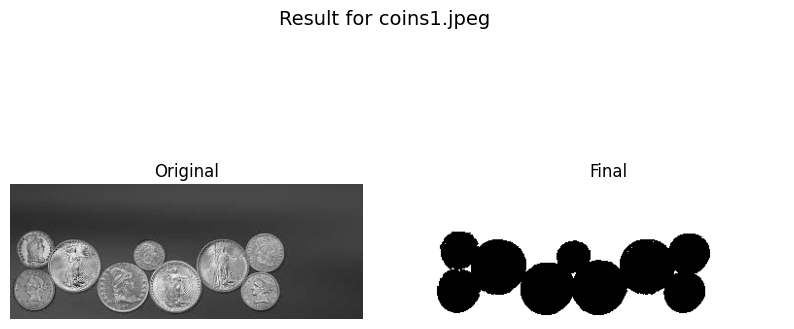

In [63]:
import cv2
import matplotlib.pyplot as plt
import os

def show_side_by_side(title, img1, img2, label1="Original", label2="Final"):
    plt.figure(figsize=(10,5))

    # Left: original
    plt.subplot(1,2,1)
    plt.imshow(img1, cmap="gray")
    plt.title(label1)
    plt.axis("off")

    # Right: processed
    plt.subplot(1,2,2)
    plt.imshow(img2, cmap="gray")
    plt.title(label2)
    plt.axis("off")

    plt.suptitle(title, fontsize=14)
    plt.show()

images = [
    "assets/coins1.jpeg",
]

# Use 3x3 ellipse kernel for closing
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))

for img_path in images:
    print(f"\nProcessing {img_path} ...")

    image = cv2.imread(img_path)
    if image is None:
        print(f"⚠️ Could not load {img_path}")
        continue
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 1: Binary inversion (coins white, bg black)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Step 2: Morphological selection (closing 3x3)
    final_mask = cv2.morphologyEx(binary, cv2.MORPH_ERODE, kernel, iterations=3)

    # Show only original vs final
    show_side_by_side(f"Result for {os.path.basename(img_path)}", gray, final_mask)



Processing assets/coins2.jpeg ...


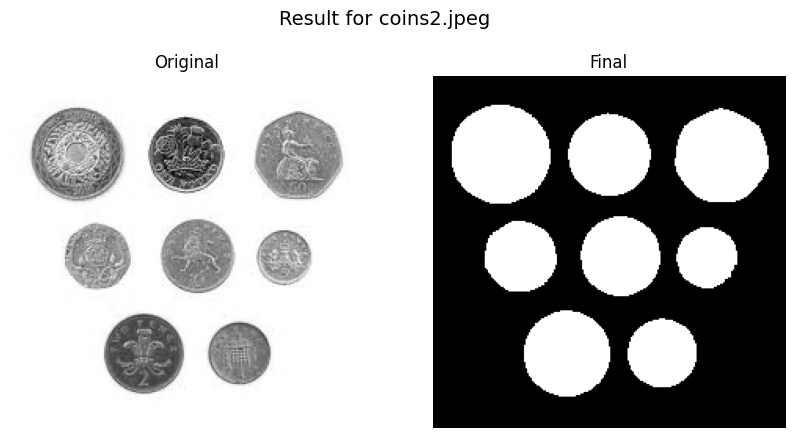


Processing assets/coins3.jpeg ...


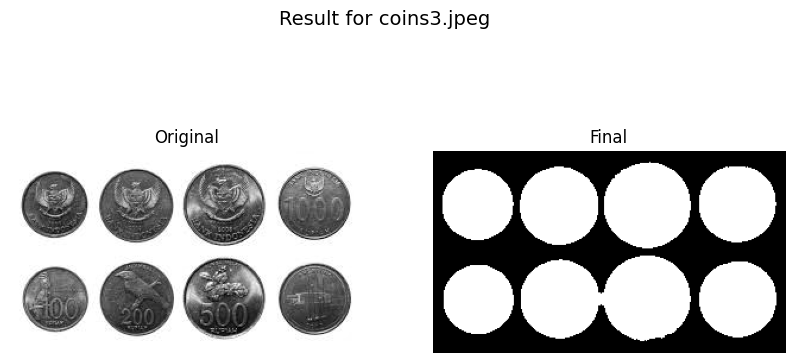


Processing assets/coins4.jpeg ...


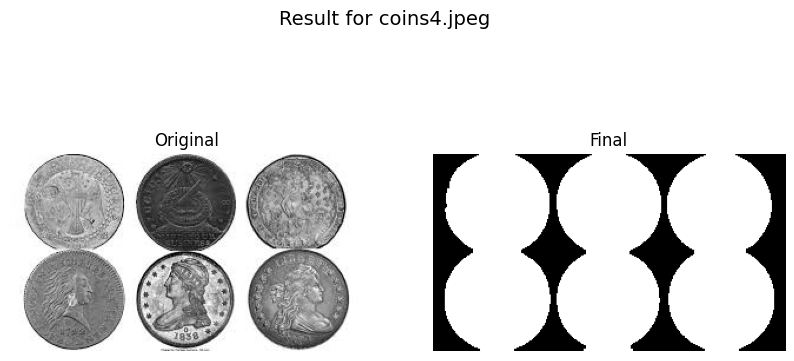

In [39]:
import cv2
import matplotlib.pyplot as plt
import os

def show_side_by_side(title, img1, img2, label1="Original", label2="Final"):
    plt.figure(figsize=(10,5))

    # Left: original
    plt.subplot(1,2,1)
    plt.imshow(img1, cmap="gray")
    plt.title(label1)
    plt.axis("off")

    # Right: processed
    plt.subplot(1,2,2)
    plt.imshow(img2, cmap="gray")
    plt.title(label2)
    plt.axis("off")

    plt.suptitle(title, fontsize=14)
    plt.show()

images = [
    "assets/coins2.jpeg",
    "assets/coins3.jpeg",
    "assets/coins4.jpeg"
]

# Use 5x5 ellipse kernel (stronger shape preservation)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))

for img_path in images:
    print(f"\nProcessing {img_path} ...")

    image = cv2.imread(img_path)
    if image is None:
        print(f"⚠️ Could not load {img_path}")
        continue
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 1: Binary inversion (coins white, bg black)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Step 2: Morphological selection (dilation + erosion)
    dilated = cv2.dilate(binary, kernel, iterations=2)
    eroded = cv2.erode(dilated, kernel, iterations=1)

    # Final mask (white coins, black bg)
    final_mask = eroded  

    # Show only original vs final
    show_side_by_side(f"Result for {os.path.basename(img_path)}", gray, final_mask)
